# Half a dozen ways to measure the difference in means in two groups in Bambi

This notebook uses Python (Bambi) to reproduce the statistical analyses from the blog post [Half a dozen frequentist and Bayesian ways to measure the difference in means in two groups](https://www.andrewheiss.com/blog/2019/01/29/diff-means-half-dozen-ways/) by Andrew Heiss.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Example movies genres

see https://www.andrewheiss.com/blog/2019/01/29/diff-means-half-dozen-ways/

see also https://bookdown.org/content/3686/metric-predicted-variable-on-one-or-two-groups.html#two-groups


In [2]:
movies = pd.read_csv("../../datasets/movies.csv")
movies.head()

,title,year,rating,genre,genre_numeric
0,Blowing Wild,1953,5.6,Action,1
1,No Way Back,1995,5.2,Action,1
2,New Jack City,1991,6.1,Action,1
3,Noigwon,1983,4.2,Action,1
4,Tarzan and the Jungle Boy,1968,5.2,Action,1


In [3]:
movies.groupby("genre")["rating"].mean()

genre
Action    5.2845
Comedy    5.9670
Name: rating, dtype: float64

In [4]:
from scipy.stats import ttest_ind

actions = movies[movies["genre"]=="Action"]["rating"]
comedies = movies[movies["genre"]=="Comedy"]["rating"]

ttest_ind(actions, comedies, equal_var=True)

TtestResult(statistic=-4.47525173500199, pvalue=9.976981171112134e-06, df=398.0)

In [5]:
ttest_ind(actions, comedies, equal_var=False)

TtestResult(statistic=-4.47525173500199, pvalue=9.978285839671783e-06, df=397.7995256063933)

In [6]:
import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
# Model formula
levels = ["Comedy", "Action"]
formula = bmb.Formula("rating ~ 1 + C(genre, levels=levels)")

# Choose custom priors 
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "C(genre, levels=levels)": bmb.Prior("Normal", mu=0, sigma=1)
}

# Build model
model_eq = bmb.Model(formula, priors=priors, data=movies)

# Get model description
print(model_eq)

       Formula: rating ~ 1 + C(genre, levels=levels)
        Family: gaussian
          Link: mu = identity
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            C(genre, levels=levels) ~ Normal(mu: 0.0, sigma: 1.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.559)


In [8]:
# model_eq.build()
# model_eq.graph()

In [9]:
# Fit the model using 1000 on each chain
idata_eq = model_eq.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, C(genre, levels=levels)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [10]:
import arviz as az
az.summary(idata_eq, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
"C(genre, levels=levels)[Action]",-0.665,0.103,-0.946,-0.381,0.002,5424.641,3120.0,1.0
Intercept,5.956,0.074,5.759,6.159,0.002,5893.353,2979.0,1.0
sigma,1.527,0.036,1.433,1.638,0.001,4891.085,3497.0,1.0


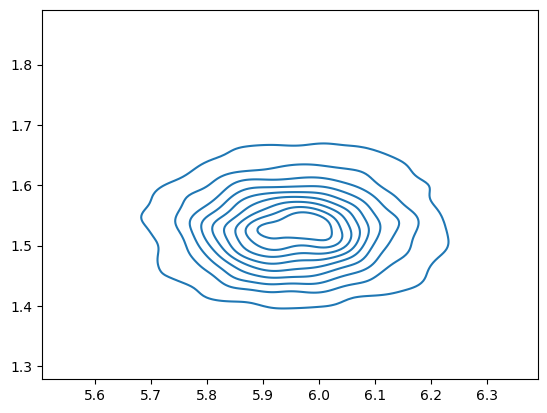

In [11]:
# JOINT PLOT
Intercept_samples = idata_eq.posterior['Intercept'].values.flatten()
sigma_samples = idata_eq.posterior['sigma'].values.flatten()
ax = sns.kdeplot(x=Intercept_samples, y=sigma_samples, fill=False)

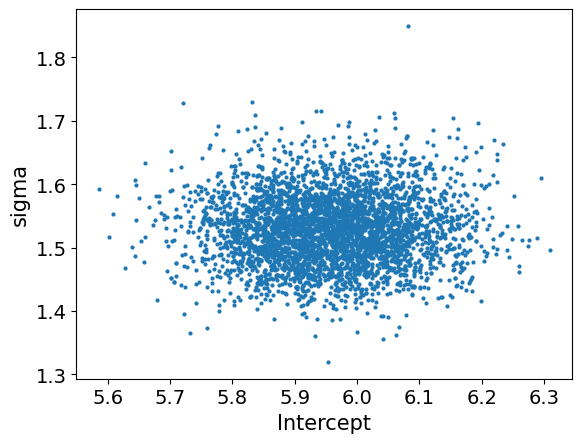

In [12]:
az.plot_pair(idata_eq, var_names=["Intercept", "sigma"]);

### Regression, assuming unequal variances


In [13]:
levels = ["Comedy", "Action"]
formula_uneq = bmb.Formula("rating ~ 1 + C(genre,levels=levels)",
                           "sigma ~ C(genre,levels=levels)")

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "C(genre, levels=levels)": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": {"C(genre, levels=levels)": bmb.Prior("Cauchy", alpha=0, beta=1)},
}

# Build model
model_uneq = bmb.Model(formula_uneq, priors=priors, data=movies)

# Get model description
print(model_uneq)
# model_uneq.build()
# model_uneq.graph()

       Formula: rating ~ 1 + C(genre,levels=levels)
                sigma ~ C(genre,levels=levels)
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            C(genre, levels=levels) ~ Normal(mu: 0.0, sigma: 1.0)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_C(genre, levels=levels) ~ Cauchy(alpha: 0.0, beta: 1.0)


In [14]:
idata_uneq = model_uneq.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(genre, levels=levels), sigma_Intercept, sigma_C(genre, levels=levels)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [15]:
az.summary(idata_uneq, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
"C(genre, levels=levels)[Action]",-0.667,0.108,-0.957,-0.374,0.003,6762.824,3161.0,1.0
Intercept,5.958,0.076,5.749,6.166,0.002,6614.842,3215.0,1.0
"sigma_C(genre, levels=levels)[Action]",-0.022,0.048,-0.158,0.108,0.001,5576.759,3008.0,1.0
sigma_Intercept,0.434,0.034,0.340,0.532,0.001,6031.981,2772.0,1.0


In [16]:
np.exp(az.summary(idata_uneq, stat_focus="median").loc["sigma_C(genre, levels=levels)[Action]","median"])

0.97824023505121

### BEST

In [17]:
levels = ["Comedy", "Action"]
formula_best = bmb.Formula("rating ~ 1 + C(genre,levels=levels)",
                           "sigma ~ C(genre,levels=levels)")

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "C(genre, levels=levels)": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": {"C(genre, levels=levels)": bmb.Prior("Cauchy", alpha=0, beta=1)},
    "nu": bmb.Prior("Exponential", lam=1/29),
}

# Build model
model_best = bmb.Model(formula_best, priors=priors, family="t", data=movies)

# Get model description
print(model_best)
# model_best.build()
# model_best.graph()

       Formula: rating ~ 1 + C(genre,levels=levels)
                sigma ~ C(genre,levels=levels)
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            C(genre, levels=levels) ~ Normal(mu: 0.0, sigma: 1.0)
        
        Auxiliary parameters
            nu ~ Exponential(lam: 0.0345)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_C(genre, levels=levels) ~ Cauchy(alpha: 0.0, beta: 1.0)


In [18]:
idata_best = model_best.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, C(genre, levels=levels), sigma_Intercept, sigma_C(genre, levels=levels)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
az.summary(idata_best, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
"C(genre, levels=levels)[Action]",-0.681,0.101,-0.956,-0.402,0.003,4149.553,2807.0,1.0
Intercept,5.979,0.072,5.784,6.174,0.003,4135.636,3242.0,1.0
nu,31.440,13.696,9.918,107.195,0.579,3248.710,1885.0,1.0
"sigma_C(genre, levels=levels)[Action]",-0.000,0.051,-0.144,0.148,0.002,3974.988,2595.0,1.0
sigma_Intercept,0.387,0.041,0.262,0.496,0.001,3561.065,2159.0,1.0


### BEST with priors on variables instead of difference




In [20]:
levels = ["Comedy", "Action"]
formula_best2 = bmb.Formula("rating ~ 0 + C(genre,levels=levels)",
                            "sigma ~ 0 + C(genre,levels=levels)")

import pymc as pm
import pytensor

def ShiftedExp(name, lam,  **kwargs):
    def shited_exp(lam, loc, size):
        return pm.Exponential.dist(lam=lam) + loc
    return pm.CustomDist(name, lam, 1, dist=shited_exp, **kwargs)

priors = {
    "C(genre, levels=levels)": bmb.Prior("TruncatedNormal", mu=6, sigma=2, lower=1, upper=10),
    "sigma": {"C(genre, levels=levels)": bmb.Prior("Cauchy", alpha=0, beta=1)},
    "nu": bmb.Prior("Exponential", lam=1/29),
    #"nu": bmb.Prior("ShiftedExp", lam=1/29.0, dist=ShiftedExp),
}

# Build model
model_best2 = bmb.Model(formula_best2, priors=priors, family="t", data=movies)

# Get model description
print(model_best2)

       Formula: rating ~ 0 + C(genre,levels=levels)
                sigma ~ 0 + C(genre,levels=levels)
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            C(genre, levels=levels) ~ TruncatedNormal(mu: 6.0, sigma: 2.0, lower: 1.0, upper: 10.0)
        
        Auxiliary parameters
            nu ~ Exponential(lam: 0.0345)
    target = sigma
        Common-level effects
            sigma_C(genre, levels=levels) ~ Cauchy(alpha: 0.0, beta: 1.0)


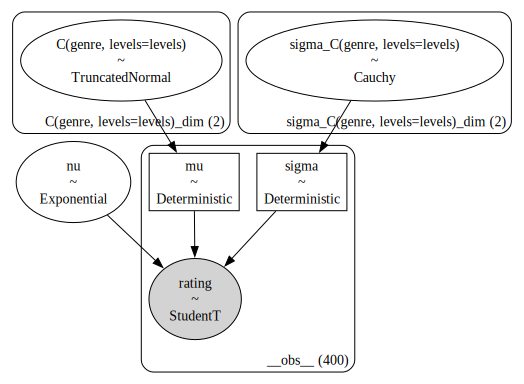

In [21]:
model_best2.build()
model_best2.graph()

In [22]:
# model_best2.plot_priors();

In [23]:
idata_best2 = model_best2.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, C(genre, levels=levels), sigma_C(genre, levels=levels)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


In [24]:
az.summary(idata_best2, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
"C(genre, levels=levels)[Comedy]",5.989,0.073,5.790,6.182,0.002,4099.678,3299.0,1.0
"C(genre, levels=levels)[Action]",5.289,0.073,5.094,5.489,0.002,3880.445,2814.0,1.0
nu,30.963,13.557,9.682,107.996,0.392,3177.571,2494.0,1.0
"sigma_C(genre, levels=levels)[Comedy]",0.385,0.041,0.268,0.497,0.001,3703.211,2374.0,1.0
"sigma_C(genre, levels=levels)[Action]",0.384,0.038,0.279,0.490,0.001,3687.923,3277.0,1.0


In [25]:
az.summary(idata_best2, stat_focus="median")

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
"C(genre, levels=levels)[Comedy]",5.989,0.073,5.790,6.182,0.002,4099.678,3299.0,1.0
"C(genre, levels=levels)[Action]",5.289,0.073,5.094,5.489,0.002,3880.445,2814.0,1.0
nu,30.963,13.557,9.682,107.996,0.392,3177.571,2494.0,1.0
"sigma_C(genre, levels=levels)[Comedy]",0.385,0.041,0.268,0.497,0.001,3703.211,2374.0,1.0
"sigma_C(genre, levels=levels)[Action]",0.384,0.038,0.279,0.490,0.001,3687.923,3277.0,1.0


In [26]:
np.exp(az.summary(idata_best2, stat_focus="median").loc["sigma_C(genre, levels=levels)[Action]","median"])

1.4681454416819895